In [1]:
import os
import cv2
import numpy as np
import mediapipe as mp

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv1D, MaxPooling1D,
    LSTM, Bidirectional,
    Dense, Dropout
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split


In [2]:
mp_hands = mp.solutions.hands

hands = mp_hands.Hands(
    static_image_mode=False,
    max_num_hands=2,
    min_detection_confidence=0.6,
    min_tracking_confidence=0.6
)


In [3]:
def pad_sequence(seq, max_len=30):
    if len(seq) >= max_len:
        return seq[:max_len]

    last = seq[-1]
    pad_len = max_len - len(seq)
    padding = np.repeat(last[np.newaxis, :], pad_len, axis=0)
    return np.vstack([seq, padding])


In [4]:
def extract_landmarks(video_path):
    cap = cv2.VideoCapture(video_path)
    sequence = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = hands.process(frame)

        keypoints = []

        for i in range(2):  # max 2 hands
            if results.multi_hand_landmarks and i < len(results.multi_hand_landmarks):
                hand_landmarks = results.multi_hand_landmarks[i]
                wrist = hand_landmarks.landmark[0]

                for lm in hand_landmarks.landmark:
                    keypoints.extend([
                        lm.x - wrist.x,
                        lm.y - wrist.y,
                        lm.z - wrist.z
                    ])
            else:
                keypoints.extend([0.0] * 63)  # 21 × 3

        sequence.append(keypoints)

    cap.release()
    return np.array(sequence)


In [5]:
DATA_PATH = "data/raw_videos"
WORDS = sorted(os.listdir(DATA_PATH))
LABEL_MAP = {word: idx for idx, word in enumerate(WORDS)}

X, y = [], []

for word in WORDS:
    folder = os.path.join(DATA_PATH, word)
    for video in os.listdir(folder):
        video_path = os.path.join(folder, video)

        seq = extract_landmarks(video_path)

        if len(seq) == 0:
            continue

        seq = pad_sequence(seq, max_len=30)

        X.append(seq)
        y.append(LABEL_MAP[word])

X = np.array(X)
y = np.array(y)

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (167, 30, 126)
y shape: (167,)


In [6]:
mean = X.mean(axis=(0,1), keepdims=True)
std  = X.std(axis=(0,1), keepdims=True) + 1e-6

X = (X - mean) / std


In [7]:
X_train, X_val, y_train_lbl, y_val_lbl = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

y_train = to_categorical(y_train_lbl, num_classes=len(WORDS))
y_val   = to_categorical(y_val_lbl, num_classes=len(WORDS))


In [8]:
model = Sequential([

    # -------- Temporal CNN --------
    Conv1D(64, kernel_size=3, activation='relu',
           input_shape=(30, 126)),
    MaxPooling1D(pool_size=2),

    # -------- Temporal RNN --------
    Bidirectional(LSTM(64, return_sequences=False)),

    Dense(64, activation='relu'),
    Dropout(0.4),

    Dense(len(WORDS), activation='softmax')
])

model.compile(
    optimizer=Adam(1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 28, 64)            24256     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 14, 64)           0         
 )                                                               
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 8)                 5

In [9]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10
    )
]

history = model.fit(
    X_train, y_train,
    epochs=150,
    batch_size=4,
    validation_data=(X_val, y_val),
    shuffle=True,
    callbacks=callbacks
)


Epoch 1/150
34/34 [==============================] - 4s 30ms/step - loss: 1.8385 - accuracy: 0.3008 - val_loss: 1.3869 - val_accuracy: 0.5882 - lr: 0.0010
Epoch 2/150
34/34 [==============================] - 0s 6ms/step - loss: 1.1660 - accuracy: 0.6391 - val_loss: 0.8681 - val_accuracy: 0.7647 - lr: 0.0010
Epoch 3/150
34/34 [==============================] - 0s 6ms/step - loss: 0.6821 - accuracy: 0.7970 - val_loss: 0.5432 - val_accuracy: 0.8235 - lr: 0.0010
Epoch 4/150
34/34 [==============================] - 0s 8ms/step - loss: 0.4350 - accuracy: 0.9023 - val_loss: 0.3930 - val_accuracy: 0.9412 - lr: 0.0010
Epoch 5/150
34/34 [==============================] - 0s 7ms/step - loss: 0.3664 - accuracy: 0.8722 - val_loss: 0.2533 - val_accuracy: 0.9412 - lr: 0.0010
Epoch 6/150
34/34 [==============================] - 0s 7ms/step - loss: 0.2430 - accuracy: 0.9398 - val_loss: 0.1962 - val_accuracy: 0.9706 - lr: 0.0010
Epoch 7/150
34/34 [==============================] - 0s 8ms/step - loss: 0.

In [10]:
model.save("isl_cnn_bilstm_126.h5")

np.save("mean.npy", mean)
np.save("std.npy", std)
np.save("labels.npy", WORDS)


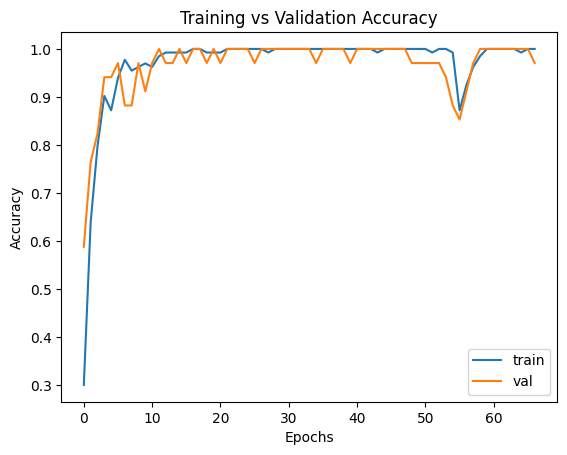

In [11]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.show()